In [90]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt

In [91]:
FILE_PATH = '/content/drive/MyDrive/dados/sonar.all-data.csv'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# LOADING, TRANSFORMING AND VISUALIZING DATA

In [92]:
df = pd.read_csv(FILE_PATH)

X = df.iloc[:,:60].to_numpy()
y = df.iloc[:,60:].to_numpy()

X = torch.from_numpy(X).to(torch.float32)

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y = torch.from_numpy(y).to(torch.float32)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

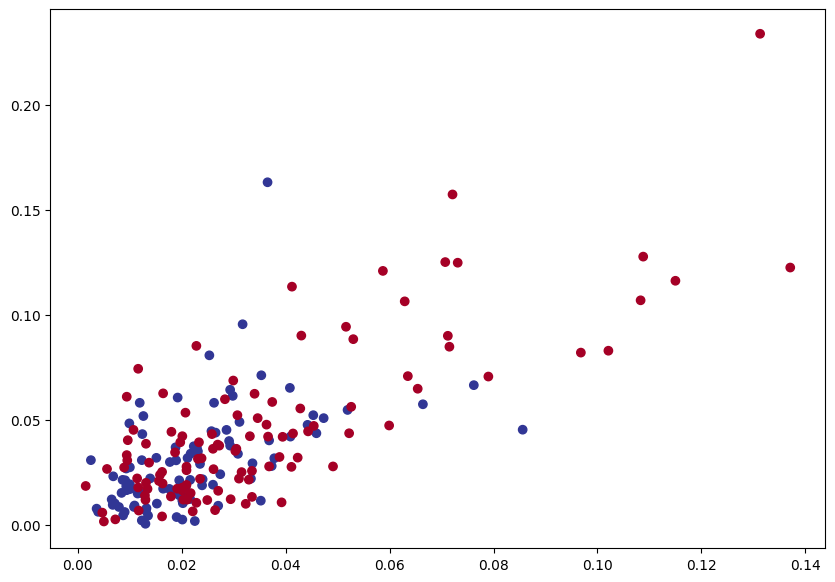

In [93]:
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [95]:
class SonarDataset(Dataset):
  def __init__(self,inputs,outputs):
    self.inputs = inputs
    self.outputs = outputs

  def __len__(self):
    return len(self.outputs)

  def __getitem__(self,idx):
    input = self.inputs[idx]
    output = self.outputs[idx]
    return input,output

In [96]:
train_dataset = SonarDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=10)

test_dataset = SonarDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset)

# MODEL AND BASIC CONFIGURATIONS

In [97]:
class RockOrMine(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(60,60),
        nn.ReLU(),
        nn.Linear(60,60),
        nn.ReLU(),
        nn.Linear(60,1)
    )

  def forward(self,x):
    return self.layers(x)

In [98]:
torch.manual_seed(42)
model = RockOrMine().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr=0.01,params=model.parameters())
epochs = 200

# TRAIN AND TEST LOOP

In [99]:
def train_loop(dataloader,model,loss_fn,optimizer):
  global device
  model.train()
  for X,y in dataloader:
    X,y = X.to(device), y.to(device)
    logits = model(X).squeeze(dim=1)
    loss = loss_fn(logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [100]:
def test_loop(dataloader,model,loss_fn):
  global device
  model.eval()
  avg_loss = 0
  avg_acc = 0
  correct_preds = 0
  total_samples = len(dataloader.dataset)
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      logits = model(X).squeeze(dim=1)
      preds = torch.round(torch.sigmoid(logits))
      loss = loss_fn(logits,y)

      avg_loss += loss.item()
      correct_preds += torch.eq(preds,y).item()

  avg_loss /= total_samples
  avg_acc = (correct_preds/total_samples)*100
  print(f'AVG_LOSS: {avg_loss:.5f} - AVG_ACC: {avg_acc:.2f}')
  return [avg_acc,avg_loss]


# TRAINING THE MODEL

In [101]:
best_acc = 0
best_weights = None
accs = []
losses = []

for epoch in range(epochs):
  print(f'EPOCH {epoch+1}')
  train_loop(train_dataloader,model,loss_fn,optimizer)
  acc,loss = test_loop(test_dataloader,model,loss_fn)
  losses.append(loss)
  accs.append(acc)
  if acc > best_acc:
    best_acc = acc
    best_weights = copy.deepcopy(model.state_dict())


model.load_state_dict(best_weights)
print('DONE!')
print(f'BEST ACC: {best_acc:.2f}')
response = input('Do you want to save the model? [y/n]:').lower()
if response == 'y':
  torch.save(model,'RockOrMine.pth')



EPOCH 1
AVG_LOSS: 0.69145 - AVG_ACC: 61.90
EPOCH 2
AVG_LOSS: 0.69057 - AVG_ACC: 69.05
EPOCH 3
AVG_LOSS: 0.68977 - AVG_ACC: 73.81
EPOCH 4
AVG_LOSS: 0.68900 - AVG_ACC: 76.19
EPOCH 5
AVG_LOSS: 0.68830 - AVG_ACC: 78.57
EPOCH 6
AVG_LOSS: 0.68759 - AVG_ACC: 76.19
EPOCH 7
AVG_LOSS: 0.68692 - AVG_ACC: 73.81
EPOCH 8
AVG_LOSS: 0.68632 - AVG_ACC: 73.81
EPOCH 9
AVG_LOSS: 0.68576 - AVG_ACC: 73.81
EPOCH 10
AVG_LOSS: 0.68522 - AVG_ACC: 73.81
EPOCH 11
AVG_LOSS: 0.68473 - AVG_ACC: 73.81
EPOCH 12
AVG_LOSS: 0.68427 - AVG_ACC: 73.81
EPOCH 13
AVG_LOSS: 0.68386 - AVG_ACC: 73.81
EPOCH 14
AVG_LOSS: 0.68348 - AVG_ACC: 73.81
EPOCH 15
AVG_LOSS: 0.68312 - AVG_ACC: 73.81
EPOCH 16
AVG_LOSS: 0.68281 - AVG_ACC: 73.81
EPOCH 17
AVG_LOSS: 0.68249 - AVG_ACC: 73.81
EPOCH 18
AVG_LOSS: 0.68216 - AVG_ACC: 73.81
EPOCH 19
AVG_LOSS: 0.68184 - AVG_ACC: 73.81
EPOCH 20
AVG_LOSS: 0.68150 - AVG_ACC: 73.81
EPOCH 21
AVG_LOSS: 0.68118 - AVG_ACC: 73.81
EPOCH 22
AVG_LOSS: 0.68085 - AVG_ACC: 73.81
EPOCH 23
AVG_LOSS: 0.68053 - AVG_ACC: 73.

[Text(0.5, 0, 'EPOCH'), Text(0, 0.5, 'ACCURACY')]

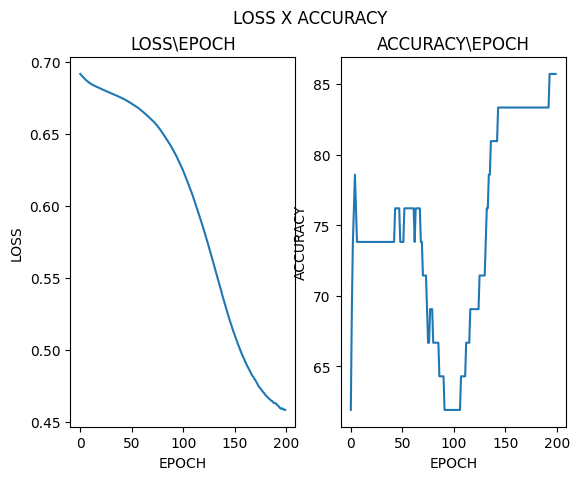

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('LOSS X ACCURACY')
ax1.plot(losses)
ax1.set_title('LOSS\EPOCH')
ax1.set(xlabel='EPOCH',ylabel='LOSS')
ax2.plot(accs)
ax2.set_title('ACCURACY\EPOCH')
ax2.set(xlabel='EPOCH',ylabel='ACCURACY')